<a href="https://colab.research.google.com/github/lauranorenab/Proyecto_Modelos_2/blob/main/02_Preprocesamiento_Car_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import files
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.io
import tkinter
import math
import os

%matplotlib inline
sns.set(color_codes=True)

En el preprocesamiento del modelo para la evaluación de vehículos, no se llevó a cabo ningún procedimiento de tratamiento de datos atípicos, nulos o duplicados. Esta decisión se tomó ya que en los resultados obtenidos durante el Análisis Exploratorio de Datos (EDA), se determinó que no existían instancias de estas problemáticas en el conjunto de datos.

## Lectura del dataset

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
car_evaluation = fetch_ucirepo(id=19)

# data (as pandas dataframes)
X_car = car_evaluation.data.features
y_car = car_evaluation.data.targets

In [ ]:
df_car = pd.concat([X_car, y_car], axis=1)

## Label Encoding

Esta técnica se utiliza para transformar las etiquetas de texto en valores numéricos ya que en este caso, se requiere que las variables categóricas sean de tipo numérico. Esto se debe hacer porque muchos algoritmos solo aceptan entradas numéricas.

Se tranforman las columnas de entrada usando lable encoding

In [ ]:
df_car_categoric_columns = list(X_car.columns)
print(df_car_categoric_columns)

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']


In [ ]:
from sklearn.preprocessing import LabelEncoder

from collections import defaultdict
x_car_label = car_evaluation.data.features

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

X_car = MultiColumnLabelEncoder(columns = df_car_categoric_columns).fit_transform(x_car_label)


In [ ]:
X_car

,buying,maint,doors,persons,lug_boot,safety
0,3,3,0,0,2,1
1,3,3,0,0,2,2
2,3,3,0,0,2,0
3,3,3,0,0,1,1
4,3,3,0,0,1,2
...,...,...,...,...,...,...
1723,1,1,3,2,1,2
1724,1,1,3,2,1,0
1725,1,1,3,2,0,1
1726,1,1,3,2,0,2


In [ ]:
y_car['class'].astype('category')
y_car['class'].unique()

array(['unacc', 'acc', 'vgood', 'good'], dtype=object)

In [ ]:
df_car = pd.concat([X_car, y_car], axis=1)
df_car

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,1,unacc
1,3,3,0,0,2,2,unacc
2,3,3,0,0,2,0,unacc
3,3,3,0,0,1,1,unacc
4,3,3,0,0,1,2,unacc
...,...,...,...,...,...,...,...
1723,1,1,3,2,1,2,good
1724,1,1,3,2,1,0,vgood
1725,1,1,3,2,0,1,unacc
1726,1,1,3,2,0,2,good


## Split de los datos

In [ ]:
def histograma(y):

  # Definir los colores para cada clase y el color predeterminado
  colores = {'acc': 'purple', 'vgood': '#9370db', 'good': 'orange', 'unacc': 'pink'}
  color_predeterminado = 'gray'

  # Obtener los datos de la clase
  clases = y['class']

  # Obtener las clases únicas
  clases_unicas = clases.unique()

  # Configurar la figura y los ejes
  plt.figure(figsize=(8, 5))

  # Iterar sobre cada clase única y crear un histograma con su respectivo color
  for clase in clases_unicas:
      # Obtener los datos para la clase actual
      datos_clase = y[y['class'] == clase]['class']

      # Obtener el color para la clase actual
      color_clase = colores.get(clase, color_predeterminado)

      # Crear el histograma para la clase actual
      plt.hist(datos_clase, edgecolor='white', linewidth=1, color=color_clase, label=clase, alpha=0.6, width=0.3)

  # Agregar leyenda
  plt.legend()

  # Establecer título y etiquetas de los ejes
  plt.title('CLASS CAR')
  plt.xlabel('Class')
  plt.ylabel('FRECUENCIA')

  # Mostrar el histograma
  plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_car, y_car,
                                                        test_size=0.2,
                                                        random_state=0,
                                                        stratify=y_car)

In [ ]:
x_train.shape, y_train.shape

((1382, 6), (1382, 1))

In [ ]:
x_test.shape, y_test.shape

((346, 6), (346, 1))

## Balanceo de clases


El balanceo se utiliza cuando existe una disparidad significativa en la cantidad de ejemplos para cada clase en un conjunto de datos dado. En este apartado se está aplicando diferentes métodos de balanceo para probar cual tiene mejores resultados.

En este caso, se escogieron los métodos:
- **SMOTE**: es una técnica de sobremuestreo, donde se agregan nuevos datos basados en los ejemplos existentes.


In [ ]:
def mostrarGrafica(y):
    # Crear un diccionario con las etiquetas de clase y el número de muestras por clase
    dicto = dict(zip(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1]))

    # Definir colores distintos para cada barra
    colores = plt.cm.tab10(np.linspace(0, 1, len(dicto)))

    # Crear la figura y los ejes
    fig, ax = plt.subplots()

    # Generar las barras con colores distintos
    for i, (clase, muestras) in enumerate(dicto.items()):
        ax.bar(clase, muestras, color=colores[i])

    # Configurar título y etiquetas de los ejes
    ax.set_title("Número de muestras por clase")
    ax.set_xlabel("etiqueta de la clase")
    ax.set_ylabel("# muestras por clase")
    ax.set_xticks(list(dicto.keys()))

    # Ocultar los bordes superior y derecho del gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

**En la siguiente gráfica se observa la existencia de un desbalance considerable:**

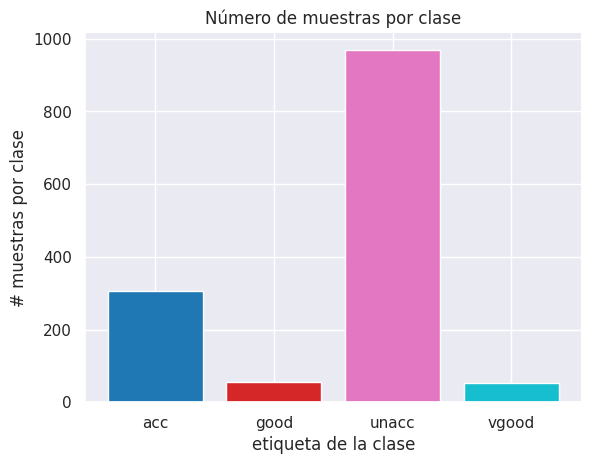

In [ ]:
mostrarGrafica(y_train)

In [ ]:
sm = SMOTE(
    sampling_strategy='auto',
    random_state=0,
    k_neighbors=5,
)
X_train_smote, y_train_smote = sm.fit_resample(x_train, y_train)

**Por este lado, se puede observar la distribución de las clases una vez se aplicó la técnica de sobremuestreo SMOTE, donde el desbalanceo desapareció totalmente:**

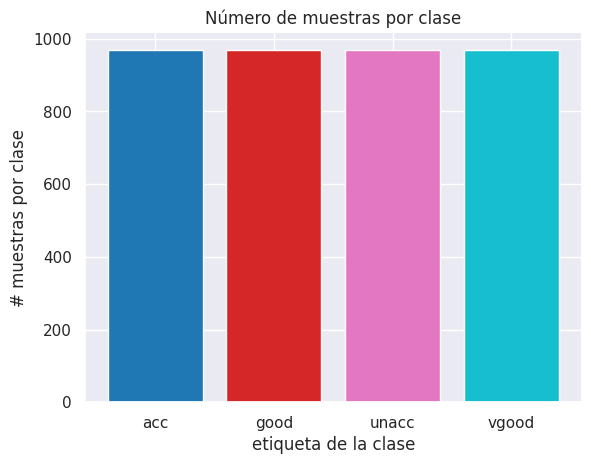

In [ ]:
mostrarGrafica(y_train_smote)

In [ ]:
X_train_smote

,buying,maint,doors,persons,lug_boot,safety
0,0,0,3,2,1,2
1,2,1,3,0,0,2
2,1,2,2,2,0,2
3,3,3,3,1,0,1
4,1,1,0,2,2,1
...,...,...,...,...,...,...
3867,1,1,1,1,0,0
3868,1,0,3,1,1,0
3869,1,0,3,2,0,0
3870,1,1,2,2,0,0


## Resumen

In [ ]:
y_train_smote['class'].shape[0]

3872

In [ ]:
y_train['class'].shape[0]

1382

In [ ]:
dataset_metrics = pd.DataFrame({
    'Dataset': ['Balanceado', 'Desbalanceado'],
    'Train': [y_train_smote['class'].shape[0], y_train['class'].shape[0]],
    'Test': [y_test['class'].shape[0], y_test['class'].shape[0]]
})

In [ ]:
dataset_metrics

,Dataset,Train,Test
0,Balanceado,3872,346
1,Desbalanceado,1382,346


## Elección de los mejores modelos y métricas

Gracias a la librería "pycaret" se realizó la evaluación de diferentes modelos junto con diferentes métricas, con el fin de determinar cuáles podrían tener mejor rendimiento y se podría implementar en este contexto de la evaluación de carros.

In [ ]:
!pip install pycaret

In [ ]:
from pycaret.classification import *

**Merjores modelos y métricas para el dataset desbalanceado**

In [ ]:
model_setup = setup(data=df_car, target='class', session_id=123)

,Description,Value
0,Session id,123
1,Target,class
2,Target type,Multiclass
3,Target mapping,"acc: 0, good: 1, unacc: 2, vgood: 3"
4,Original data shape,"(1728, 7)"
5,Transformed data shape,"(1728, 7)"
6,Transformed train set shape,"(1209, 7)"
7,Transformed test set shape,"(519, 7)"
8,Numeric features,6
9,Preprocess,True


In [ ]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9909,0.9997,0.9909,0.9917,0.9910,0.9802,0.9803,0.8950
xgboost,Extreme Gradient Boosting,0.9859,0.9997,0.9859,0.9872,0.9859,0.9694,0.9697,0.1400
gbc,Gradient Boosting Classifier,0.9826,0.0000,0.9826,0.9837,0.9826,0.9623,0.9626,0.7980
dt,Decision Tree Classifier,0.9752,0.9790,0.9752,0.9773,0.9752,0.9458,0.9463,0.0440
rf,Random Forest Classifier,0.9702,0.9986,0.9702,0.9714,0.9695,0.9343,0.9350,0.2540
et,Extra Trees Classifier,0.9611,0.9968,0.9611,0.9634,0.9598,0.9145,0.9152,0.2210
knn,K Neighbors Classifier,0.9082,0.9708,0.9082,0.9115,0.9003,0.7868,0.7920,0.0700
ada,Ada Boost Classifier,0.7577,0.0000,0.7577,0.7607,0.7538,0.4749,0.4794,0.2340
ridge,Ridge Classifier,0.7006,0.0000,0.7006,0.5948,0.6277,0.1247,0.1522,0.0480
dummy,Dummy Classifier,0.7006,0.5000,0.7006,0.4908,0.5772,0.0000,0.0000,0.0420


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Para el caso del dataset **desbalanceado**, se puede observar que varios modelos presentan muy buenos resultados. Sin embargo, algunos modelos presentan resultados bastante deficientes por lo que quedan descartados para implementarse en este problema.

Los valores en "0" de la métrica AUC (Área Bajo la Curva) pueden ocurrir debido a que se está evaluando como un problema biclass cuando en realidad se trata de un contexto multiclass.

**Conclusión:**
Para la elección de los tres modelos a implementar, se tomaron aquellos que presentaran una mejor eficiencia o valores más altos en sus métricas en ambos dataset.

Dicho esto, se tenían varios modelos que cumplieran estos requisitos pero se decidió por los tres más comunes en cuanto a nuestra investigación:

*   Decision Tree Classifier
*   Random Forest Classifier
*   Extreme Gradient Boosting



## Descarga del dataset

Conjuto de datos desbalanceados para entrenamiento

In [ ]:
df = pd.concat([x_train, y_train], axis=1)
df.to_csv('df_train_unbalanced.csv', index=False)
files.download('df_train_unbalanced.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Conjuto de datos balanceado para entrenamiento

In [ ]:
df = pd.concat([X_train_smote, y_train_smote], axis=1)
df.to_csv('df_train_balanced.csv', index=False)
files.download('df_train_balanced.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Conjuto de datos para test

In [ ]:
df = pd.concat([x_test, y_test], axis=1)
df.to_csv('df_test.csv', index=False)
files.download('df_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>